# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.shape

(7591, 2)

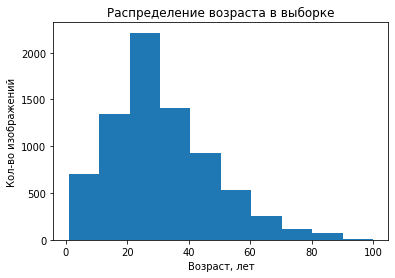

In [13]:
df.real_age.plot.hist()
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Кол-во изображений');

In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


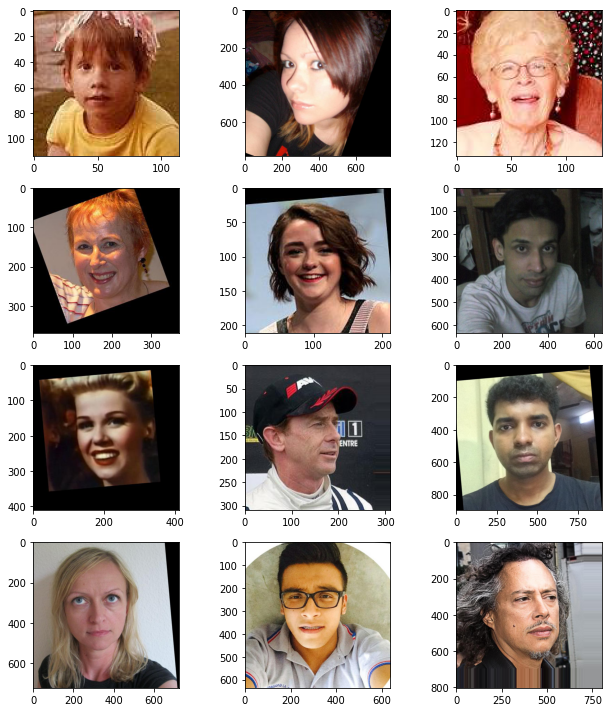

In [7]:
fig = plt.figure(figsize=(10,10))

path = '/datasets/faces/final_files/'

for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(plt.imread(path+df.file_name[i]))
    plt.tight_layout()

**Выводы:**
* Изображения в датасете разного размера. Нужно приводить к стандартному.
* Изображения выровнены по вертикали, поэтому аугментации [поворот, отражение по вертикали], наверное, не потребуются. Отражение по горизонтали можно применить, для улучшения обучения.
* Основная масса изображений приходится на возраст 10-40 лет. Модель будет хорошо предсказывать в этом диапазоне и завышать / занижать возраст для людей моложе / старше.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):  
    datagen = ImageDataGenerator(
            validation_split=0.15,
            rescale=1/255)  
        
    df = pd.read_csv(path + 'labels.csv')
    
    datagen_flow = datagen.flow_from_dataframe(
            dataframe= df,
            directory= path + '/final_files',
            x_col= 'file_name',
            y_col= 'real_age',
            batch_size=16,
            class_mode='raw',
            seed=12345,
            subset='training')
    
    return datagen_flow


def load_test(path):  
    datagen = ImageDataGenerator(
            validation_split=0.15,
            rescale=1/255)  
        
    df = pd.read_csv(path + 'labels.csv')
    
    datagen_flow = datagen.flow_from_dataframe(
            dataframe= df,
            directory= path + '/final_files',
            x_col= 'file_name',
            y_col= 'real_age',
            batch_size=16,
            class_mode='raw',
            seed=12345,
            subset='validation')
    
    return datagen_flow


def create_model(input_shape):
    resnet= ResNet50(
            include_top=False, 
            weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
            input_shape= input_shape)
    
    model = Sequential()
    model.add(resnet)
    # слои взамен отключенных
    model.add(GlobalAvgPool2D())
    model.add(Dense(1, activation='relu'))
    
    # уменьшение шага Adam
    model.compile(optimizer=Adam(0.0002), 
                  loss='mae',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, 
                epochs=4, 
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch==None:
        steps_per_epoch=len(train_data)
    if validation_steps==None:
        validation_steps=len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

```
2023-06-17 08:00:39.029773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-06-17 08:00:39.031877: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-06-17 08:00:39.976140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-17 08:00:40.762540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-06-17 08:00:40.762646: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-17 08:00:40.762720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-17 08:00:40.764969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-17 08:00:40.765459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-06-17 08:00:40.768023: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-06-17 08:00:40.769542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-06-17 08:00:40.769623: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-06-17 08:00:40.774937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6453 validated image filenames.
Found 1138 validated image filenames.
2023-06-17 08:00:40.960851: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-06-17 08:00:40.968726: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2023-06-17 08:00:40.969725: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x585afd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-17 08:00:40.969762: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-17 08:00:41.417864: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4ebb130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-17 08:00:41.417903: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-06-17 08:00:41.420059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-06-17 08:00:41.420144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-17 08:00:41.420158: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-17 08:00:41.420180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-06-17 08:00:41.420190: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-06-17 08:00:41.420200: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-06-17 08:00:41.420209: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-06-17 08:00:41.420216: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-06-17 08:00:41.424186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-06-17 08:00:41.424267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-17 08:00:41.756431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-06-17 08:00:41.756479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-06-17 08:00:41.756487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-06-17 08:00:41.760165: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-17 08:00:41.760213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 404 steps, validate for 72 steps
Epoch 1/4
2023-06-17 08:00:51.741054: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-17 08:00:52.117440: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
404/404 - 77s - loss: 10.1190 - mae: 10.1209 - val_loss: 18.5861 - val_mae: 18.7147
Epoch 2/4
404/404 - 49s - loss: 7.6016 - mae: 7.6033 - val_loss: 8.3938 - val_mae: 8.3347
Epoch 3/4
404/404 - 59s - loss: 6.5186 - mae: 6.5183 - val_loss: 8.7186 - val_mae: 8.6973
Epoch 4/4
404/404 - 60s - loss: 5.9085 - mae: 5.9062 - val_loss: 6.6796 - val_mae: 6.7459
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
72/72 - 6s - loss: 6.6796 - mae: 6.7459
Test MAE: 6.7459
```

## Анализ обученной модели

Результаты тестов моделей

|#|Val_split |Epochs|Adam learn_rate |Rotation |MAE|Comment|
|--|------|-----------------|----------|--|--|--|
|1|0.25|2|0.0001|None|11.0248|
|2|0.25|**4**|0.0001|None|7.2908|
|3|**0.15**|4|0.0001|None|6.7295|
|4|**0.10**|4|0.0001|None|7.1251|
|5|**0.15**|4|0.0001|**10**|10.9664|
|6|0.15|4|0.0001|**None**|7.1397|back to #3
|7|0.15|**5**|0.0001|None|8.1805|
|8|0.15|**4**|**0.00015**|None|7.0399|
|9|0.15|4|**0.0002**|None|6.7459|**Выбрал эту модель**
|10|0.15|4|**0.00025**|None|7.4818|

**Выводы:**
* Увеличение обучающей выборки за счет валидационной улучшает результат;
* Увеличение кол-ва эпох до определенного момента дает положительный результат. Дальнейшее увеличение приводит к переобучению;
* Аугментация (поворот) ухудшила результат. Вероятно потому, что изображения в наборе данных предварительно выровнены.
* Уменьшение learning_rate до определенного момента дает положительный результат. Дальнейшее уменьшение приводит к переобучению;

**Общий вывод**

* Проведен небольшой исследовательский анализ данных.
* В модели использовался алгоритм ResNet50 с предобученными весами.
* Достигнута MAE = 6,75
* Исходя из условий задания (цитата: *если вы получите MAE меньше 7, это будет отличный результат!*) модель можно рекомендовать к применению.
* При необходимости дополнительной оптимизации, можно использовать аугментацию - horizontal_flip на обучающей выборке.